In [1]:
import torch
from tqdm.notebook import tqdm

# from transformers import BertTokenizer
from transformers import AlbertTokenizer

from torch.utils.data import TensorDataset

import transformers
# from transformers import BertForSequenceClassification
from transformers import AlbertForSequenceClassification

import numpy as np
import pandas as pd
import re


In [2]:
df = pd.read_csv('./Corona_NLP_train.csv', encoding='latin-1')
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [3]:
def extract_hash_tags(s):
    hashes = re.findall(r"#(\w+)", s)
    return " ".join(hashes)
df['hashtags'] = df['OriginalTweet'].apply(lambda x : extract_hash_tags(x))

In [4]:
def extract_mentions(s):
    hashes = re.findall(r"@(\w+)", s)
    return " ".join(hashes)
df['mentions'] = df['OriginalTweet'].apply(lambda x : extract_mentions(x))

In [5]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y = df['Sentiment']



encoding = {'Extremely Negative': 0,
            'Negative': 0,
            'Neutral': 1,
            'Positive':2,
            'Extremely Positive': 2
           }

labels = ['Negative', 'Neutral', 'Positive']


y.replace(encoding, inplace=True)

df['encoded_sentiment'] = encoder.fit_transform(y)

In [6]:
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x: ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split()))

In [7]:
from sklearn.model_selection import train_test_split

xtrain, xval, ytrain, yval = train_test_split(df['OriginalTweet'], df['encoded_sentiment'], test_size = 0.2)

In [8]:
tokenizer = transformers.AlbertTokenizer.from_pretrained("albert-base-v2",do_lower_case=True)

In [9]:
encoded_data_train = tokenizer.batch_encode_plus(
    xtrain, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=50, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    xval, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=50, 
    return_tensors='pt'
)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/anaconda/envs/py37_default/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [10]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(ytrain.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(yval.values)


# Pytorch TensorDataset Instance
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [11]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [12]:
model = transformers.AlbertForSequenceClassification.from_pretrained("albert-base-v2",
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

In [13]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=128)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=128)

In [14]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 10

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [15]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [16]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
device = torch.device('cuda')

In [17]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [18]:
model.to(device)

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0].to(device),
                  'attention_mask': batch[1].to(device),
                  'labels':         batch[2].to(device),
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)
    
    # write training loss
    train_loss, train_predictions, train_vals = evaluate(dataloader_train)
#     writer.add_scalar("logs/AlbertLoss/train", loss_train_avg, epoch)
    x = 0
    preds_flat = np.argmax(train_predictions, axis=1).flatten()
    labels_flat = train_vals.flatten()
    for i in range(len(preds_flat)):
        if labels_flat[i] == preds_flat[i]:
            x += 1
    acc_train_avg = x/len(preds_flat)
    writer.add_scalar("logs/AlbertAcc/train", acc_train_avg, epoch)
    tqdm.write(f'Training Acc: {acc_train_avg}')
    # calculate validatin loss and write
    val_loss, val_predictions, val_vals = evaluate(dataloader_validation)
#     writer.add_scalar("logs/AlbertLoss/val", val_loss, epoch)
    x = 0
    preds_flat = np.argmax(val_predictions, axis=1).flatten()
    labels_flat = val_vals.flatten()
    for i in range(len(preds_flat)):
        if labels_flat[i] == preds_flat[i]:
            x += 1
    acc_val_avg = x/len(preds_flat)
    writer.add_scalar("logs/AlbertAcc/val", acc_val_avg, epoch)
    tqdm.write(f'Training Acc: {acc_val_avg}')
    
    tqdm.write(f'Training loss: {loss_train_avg}')


Epoch 1
Training Acc: 0.815459377372817
Training Acc: 0.8044217687074829
Training loss: 0.7392052764347358



Epoch 2
Training Acc: 0.8783295368261199
Training Acc: 0.8566569484936832
Training loss: 0.44691880382308663



Epoch 3
Training Acc: 0.9074259681093394
Training Acc: 0.8771865889212828
Training loss: 0.34922012761812804



Epoch 4
Training Acc: 0.9239483675018982
Training Acc: 0.8872691933916423
Training loss: 0.2876739645766657



Epoch 5
Training Acc: 0.9373728170083523
Training Acc: 0.8929786200194364
Training loss: 0.23785059052959892



Epoch 6
Training Acc: 0.9452695520121488
Training Acc: 0.8888483965014577
Training loss: 0.19765566465582035



Epoch 7
Training Acc: 0.9604555808656037
Training Acc: 0.8923712342079689
Training loss: 0.16141088664993758



Epoch 8
Training Acc: 0.9682915717539863
Training Acc: 0.891885325558795
Training loss: 0.13317895453971948



Epoch 9
Training Acc: 0.9753378891419894
Training Acc: 0.891885325558795
Training loss: 0.1107561585977096



Epoch 10
Training Acc: 0.9782536066818527
Training Acc: 0.891642371234208
Training loss: 0.09372863327983276



In [19]:
writer.flush()

In [20]:
writer.close()

In [23]:
writer

In [19]:
val_loss, predictions, true_vals = evaluate(dataloader_validation)
val_f1 = f1_score_func(predictions, true_vals)
print('Val Loss = ', val_loss)
print('Val F1 = ', val_f1)

Val Loss =  0.36984656063409954
Val F1 =  0.8783166531625034


In [20]:
encoded_classes = encoder.classes_
predicted_category = [encoded_classes[np.argmax(x)] for x in predictions]
true_category = [encoded_classes[x] for x in true_vals]

In [21]:
x = 0
for i in range(len(true_category)):
    if true_category[i] == predicted_category[i]:
        x += 1
        
print('Accuracy Score = ', x / len(true_category))

Accuracy Score =  0.8787657920310982


In [22]:
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(y_true = true_category, y_pred = predicted_category, labels=list(encoded_classes))

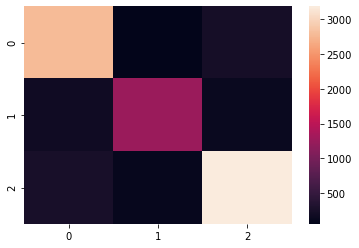

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.DataFrame(confusion_mat, index = list(encoded_classes),columns = list(encoded_classes))
sns.heatmap(df)

# Evaluation

In [24]:
test_df = pd.read_csv('./Corona_NLP_test.csv', encoding='latin-1')

test_df['hashtags'] = test_df['OriginalTweet'].apply(lambda x : extract_hash_tags(x))

test_df['mentions'] = test_df['OriginalTweet'].apply(lambda x : extract_mentions(x))

ytest = test_df['Sentiment']

ytest.replace(encoding, inplace=True)

test_df['encoded_sentiment'] = encoder.fit(ytest)

test_df['OriginalTweet'] = test_df['OriginalTweet'].apply(lambda x: ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split()))

xtest = test_df.OriginalTweet

encoded_data_test = tokenizer.batch_encode_plus(
    xtest, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=50, 
    return_tensors='pt'
)


input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(ytest.values)


# Pytorch TensorDataset Instance
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

/anaconda/envs/py37_default/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [25]:
dataloader_testing = DataLoader(dataset_test, 
                                   sampler=SequentialSampler(dataset_test), 
                                   batch_size=128)

In [26]:
test_loss, predictions, true_vals = evaluate(dataloader_testing)
test_f1 = f1_score_func(predictions, true_vals)
print('Test Loss = ', test_loss)
print('Test F1 = ', test_f1)

Test Loss =  0.39348272879918417
Test F1 =  0.8638112889540698


In [27]:
encoded_classes = encoder.classes_
predicted_category = [encoded_classes[np.argmax(x)] for x in predictions]
true_category = [encoded_classes[x] for x in true_vals]
x = 0
for i in range(len(true_category)):
    if true_category[i] == predicted_category[i]:
        x += 1
        
print('Accuracy Score = ', x / len(true_category))

Accuracy Score =  0.8644023170089521


In [30]:
predictions

array([[ 2.5422733, -1.5299261, -1.3479844],
       [-1.5763834, -1.0507784,  3.5031831],
       [-1.5015876, -1.6305078,  3.9209301],
       ...,
       [-2.1618435,  2.6784325, -1.2939514],
       [ 2.6491485, -1.5153286, -1.779066 ],
       [-1.62269  , -1.5236105,  4.012443 ]], dtype=float32)

In [35]:
np.savetxt("./predictions/albert.csv", predictions, delimiter=",")